In [13]:
import itertools
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Subset, random_split, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import product
from torch.utils.data import Dataset

In [ ]:
class PairedDataset(Dataset):
    def __init__(self, base_dataset):
        # Store the data
        self.pairs = []
        self.labels = []

        # Extract all (image, label) pairs
        data = [(img, label) for img, label in base_dataset]

        # Create all combinations
        for (img1, label1), (img2, label2) in product(data, data):
            self.pairs.append((img1, img2))
            self.labels.append(int(label1 == label2))

    def __len__(self):
        # Return the number of samples
        return len(self.pairs)

    def __getitem__(self, idx):
        # Return ((image_A, image_B), label) for this index
        img1, img2 = self.pairs[idx]
        label = self.labels[idx]
        return (img1, img2), torch.tensor(label, dtype=torch.float32)

In [15]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__() # nn.Module is the parent class
        # NOT calling these functions here, just storing the layer
        # Kalıp Gibi.
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) # 1 for grayscale img, 64 feature maps, 3x3 convolution window, 1 pixel move for each step, 1-pixel border around the image, gives output of shape (batch_size, 64, 28, 28)
        self.bn1 = nn.BatchNorm2d(64) # Normalization, keeps its mean 0 and variance 1

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # (in_channels, out_channels, kernel_size, ...)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.global_pool = nn.AdaptiveAvgPool2d(1) # (batch_size, 512, 28, 28) --> (batch_size, 512). squeezes each 28 × 28 feature map into a single number, using average pooling.

        self.embedding = nn.Linear(512, 64) # Like Dense(64) in Keras, "Take this 512-dimensional vector (summary of the image), and map it down to 64 numbers."

        # After CNN:
        self.fc1 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1) # final output layer

    def cnn(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # runs the convolution layer on input x, normalizes the result, applies ReLU activation
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        x = self.global_pool(x) # shape: [batch, 512, 1, 1]
        x = x.view(x.size(0), -1) # shape: [batch, 512]
        x = self.embedding(x) # shape: [batch, 64]
        return x

    def forward(self, imgA, imgB):
        # Extract features from both images
        featA = self.cnn(imgA)               # shape: [batch, 64]
        featB = self.cnn(imgB)

        # Concatenate embeddings
        x = torch.cat([featA, featB], dim=1) # shape: [batch, 128]

        # Compare / MLP (Multi-Layer Perceptron)
        x = F.relu(self.fc1(x))              # shape: [batch, 64]
        x = torch.sigmoid(self.out(x))       # shape: [batch, 1] — similarity score, sigmoid activation function, output between [0-1]
        return x


In [16]:
# Datayı hazırlamak için 1
transform = transforms.Compose([
    transforms.ToTensor(),                            # Converts to tensor and scales to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))        # Normalizes using MNIST mean and std
])
# loading the full dataset
full_train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

In [17]:
train_size = 200 # Datayı hazırlamak için 2
validation_size = 50
test_size = 50

In [18]:
# Datayı hazırlamak için 3
train_validation_subset, _ = random_split(full_train_dataset, [train_size + validation_size, len(full_train_dataset) - (train_size + validation_size)], generator=torch.Generator().manual_seed(42))
train_subset, validation_subset = random_split(train_validation_subset, [train_size, validation_size], generator=torch.Generator().manual_seed(42))
test_subset, _ = random_split(test_dataset, [test_size, len(test_dataset) - test_size], generator=torch.Generator().manual_seed(42))

In [19]:
# Datayı hazırlamak için 4
paired_train_dataset = PairedDataset(train_subset)
paired_val_dataset = PairedDataset(validation_subset)
paired_test_dataset = PairedDataset(test_subset)
print(len(paired_train_dataset))  # 35×35 = 1225

40000


In [20]:
# Datayı hazırlamak için 5
batch_size = 8

# Batches the data
train_loader = DataLoader(paired_train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(paired_val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(paired_test_dataset, batch_size=batch_size, shuffle=True)

In [21]:
for (imgA, imgB), labels in train_loader:
    print(imgA.shape)
    print(imgB.shape)
    print(labels.shape)
    break


torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8])


In [22]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [23]:
model = SiameseNetwork().to(device)
criterion = nn.BCELoss() # Binary Cross Entropy Loss, used to compute the loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer updates model weights during training.

In [24]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for (imgA, imgB), labels in train_loader:
        imgA, imgB, labels = imgA.to(device), imgB.to(device), labels.to(device) # Moves data to GPU
        outputs = model(imgA, imgB)
        loss = criterion(outputs, labels.unsqueeze(1)) # compares models prediction and the correct answer
        optimizer.zero_grad() # Clear previous gradients (weight change needs)
        loss.backward() # Figures out how much each weight needs to change to make the prediction better
        optimizer.step() # Changing the weights using the advice calculated by .backward()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():  # Disables gradient tracking for faster performance
        for (imgA, imgB), labels in validation_loader:
            imgA, imgB, labels = imgA.to(device), imgB.to(device), labels.to(device)
            outputs = model(imgA, imgB)
            predictions = (outputs > 0.5).float()  # Binary prediction
            correct += (predictions == labels.unsqueeze(1)).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")

    torch.save(model.state_dict(), "siamese_model_epoch20_bs8_train200_testval50_20250723.pth")
    print("Model saved as siamese_model_epoch20_bs8_train200_testval50_20250723.pth")

Epoch [1/20] - Loss: 0.3116
Validation Accuracy: 0.8920
Model saved as siamese_model_epoch20_bs8_train200_testval50_20250723.pth
Epoch [2/20] - Loss: 0.2497
Validation Accuracy: 0.8976
Model saved as siamese_model_epoch20_bs8_train200_testval50_20250723.pth
Epoch [3/20] - Loss: 0.1744
Validation Accuracy: 0.9284
Model saved as siamese_model_epoch20_bs8_train200_testval50_20250723.pth
Epoch [4/20] - Loss: 0.0883
Validation Accuracy: 0.9420
Model saved as siamese_model_epoch20_bs8_train200_testval50_20250723.pth
Epoch [5/20] - Loss: 0.0379
Validation Accuracy: 0.9292
Model saved as siamese_model_epoch20_bs8_train200_testval50_20250723.pth
Epoch [6/20] - Loss: 0.0259
Validation Accuracy: 0.9404
Model saved as siamese_model_epoch20_bs8_train200_testval50_20250723.pth
Epoch [7/20] - Loss: 0.0138
Validation Accuracy: 0.9508
Model saved as siamese_model_epoch20_bs8_train200_testval50_20250723.pth
Epoch [8/20] - Loss: 0.0179
Validation Accuracy: 0.9412
Model saved as siamese_model_epoch20_bs8_

In [25]:
# Load previously saved model (optional)
model.load_state_dict(torch.load("siamese_model_epoch20_bs8_train200_testval50_20250723.pth", map_location=device))
model.eval()
print("Loaded pre-trained model.")

Loaded pre-trained model.


In [26]:
model.eval()  # Set to eval mode
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients -- INFERENCE
    for (imgA, imgB), labels in test_loader:
        imgA, imgB, labels = imgA.to(device), imgB.to(device), labels.to(device)
        outputs = model(imgA, imgB)
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Final Test Accuracy: 0.9160


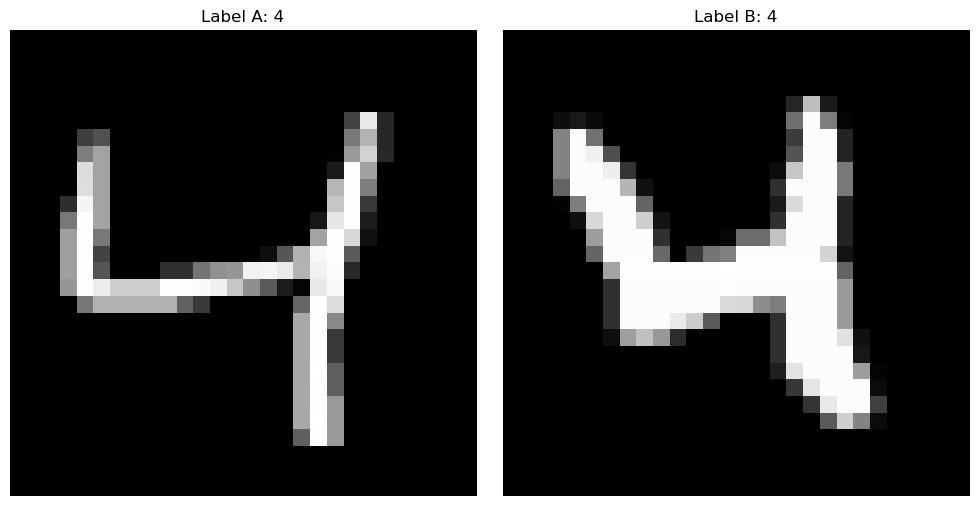

Prediction (similarity score): 0.9985173345
Actual: 1


In [39]:
idx1, idx2 = 2, 20
img1, label1 = full_train_dataset[idx1]
img2, label2 = full_train_dataset[idx2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img1.squeeze(), cmap="gray")
ax1.set_title(f"Label A: {label1}")
ax1.axis("off")

ax2.imshow(img2.squeeze(), cmap="gray")
ax2.set_title(f"Label B: {label2}")
ax2.axis("off")

plt.tight_layout()
plt.show()

img1 = img1.unsqueeze(0).to(device)
img2 = img2.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    similarity_score = model(img1, img2).item()

print(f"Prediction (similarity score): {similarity_score:.10f}")
print(f"Actual: {int(label1 == label2)}")